In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import ast

filename = 'top_500.csv'
file = f'../data/01_raw/{filename}'

def parse_list_str(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

# wczytanie danych
try:
    data = pd.read_csv(file)
    print(f"Plik '{file}' został poprawnie wczytany.")
except Exception as e:
    print(f"Błąd podczas wczytywania pliku: {e}")
    data = pd.DataFrame()

Plik '../data/01_raw/top_500.csv' został poprawnie wczytany.


In [14]:
# podstawowe informacje
info = pd.DataFrame({
    'Typ kolumny': data.dtypes,
    'Brakujące wartości': data.isnull().sum(),
    'Unikalne wartości': data.nunique()
})

print(f"Rozmiar danych: {data.shape[0]} × {data.shape[1]}\n")
display(info)

Rozmiar danych: 498 × 47



,Typ kolumny,Brakujące wartości,Unikalne wartości
appid,int64,0,498
name,object,0,465
release_date,object,0,427
required_age,int64,0,6
price,float64,0,42
dlc_count,int64,0,51
detailed_description,object,32,433
about_the_game,object,32,433
short_description,object,29,436
reviews,object,312,167


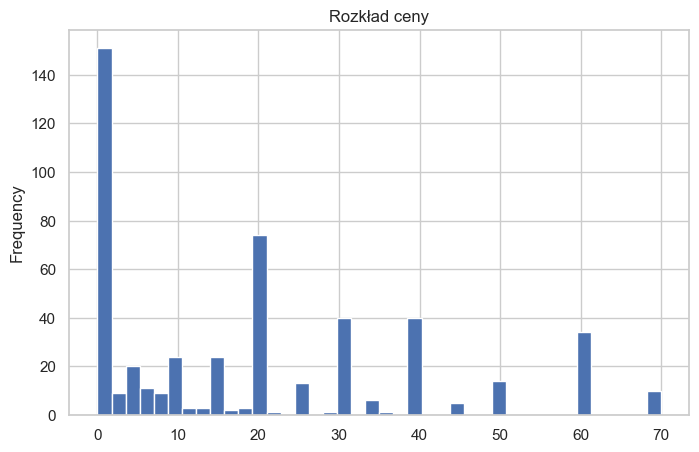

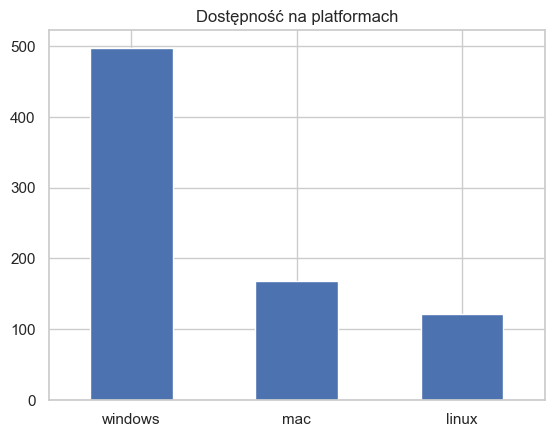

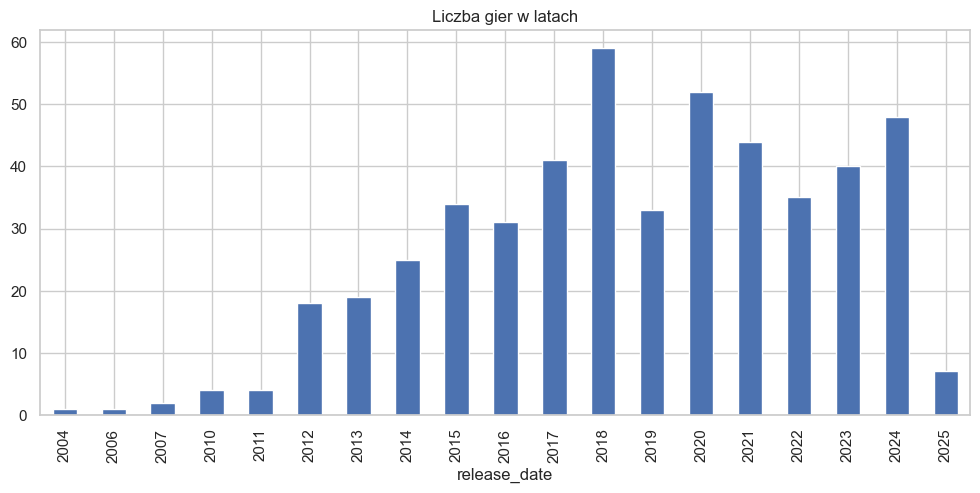

In [15]:
# wykresy numeryczne
sns.set_theme(style="whitegrid")

num_cols = data.select_dtypes(include=['int64', 'float64']).columns

if 'price' in data.columns:
    data['price'].plot(kind="hist", bins=40, figsize=(8, 5))
    plt.title("Rozkład ceny")
    plt.show()

platform_cols = [c for c in ['windows', 'mac', 'linux'] if c in data.columns]
if platform_cols:
    data[platform_cols].sum().plot(kind="bar", rot=0)
    plt.title("Dostępność na platformach")
    plt.show()

if 'release_date' in data.columns:
    pd.to_datetime(data['release_date'], errors="coerce").dt.year.value_counts().sort_index().plot(
        kind='bar', figsize=(12, 5)
    )
    plt.title("Liczba gier w latach")
    plt.show()

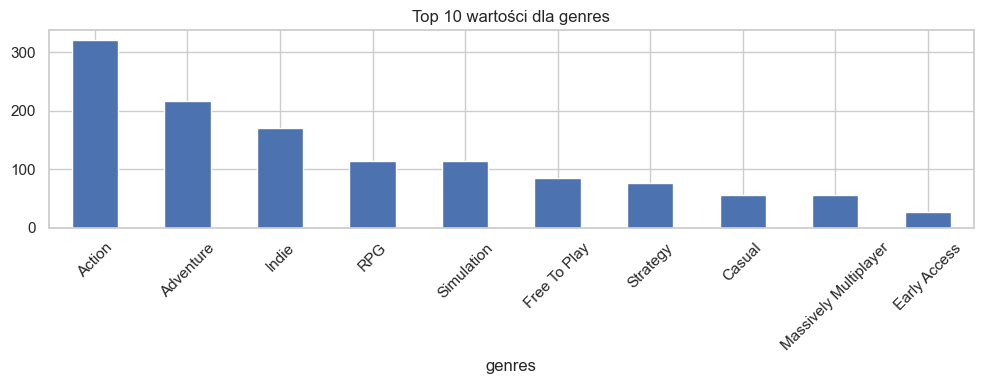

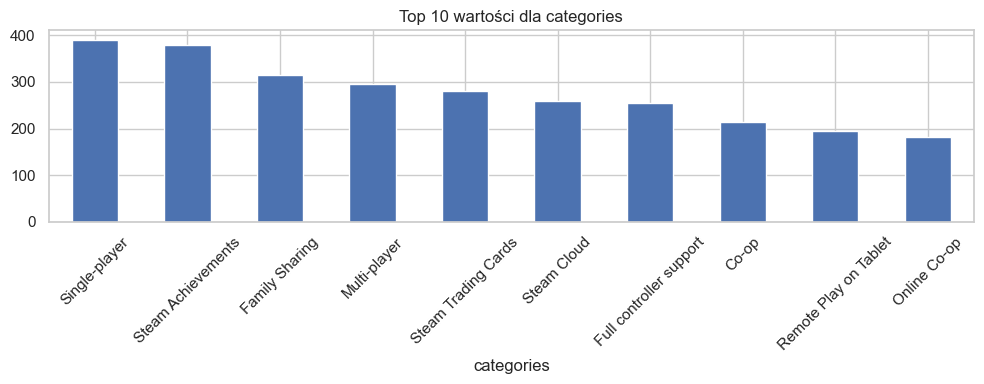

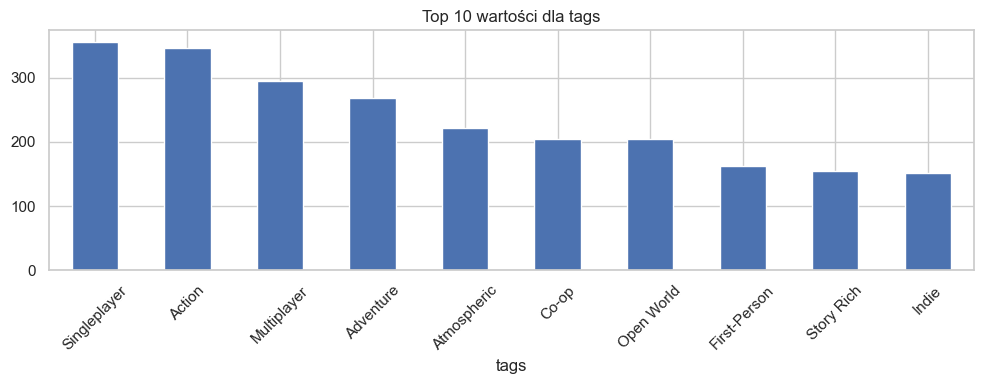

In [16]:
# wykresy kategorii
cat_cols = ['genres', 'categories', 'tags']

for col in cat_cols:
    if col not in data.columns:
        continue

    exploded = data[col].dropna().apply(parse_list_str).explode()
    counts = exploded.value_counts()

    if len(counts) == 0:
        continue

    top10 = counts.head(10)

    plt.figure(figsize=(10, 4))
    top10.plot(kind='bar')
    plt.title(f"Top 10 wartości dla {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
# czyszczenie kolumn
threshold = 0.3
for col in data.columns.tolist():
    if data[col].isnull().mean() > threshold:
        print(f"[DROP] {col}")
        data.drop(columns=[col], inplace=True)

if {'positive', 'negative'}.issubset(data.columns):
    data.drop(columns=['positive', 'negative'], inplace=True)

# release_date → rok, miesiąc
if 'release_date' in data.columns:
    data['release_date'] = pd.to_datetime(data['release_date'], errors="coerce")
    data['release_year'] = data['release_date'].dt.year
    data['release_month'] = data['release_date'].dt.month
    data.drop(columns=['release_date'], inplace=True)

# flagi binarne
bin_cols = [
    'website', 'support_url', 'detailed_description', 'about_the_game', 'short_description',
    'header_image', 'screenshots', 'movies'
]

for col in bin_cols:
    if col in data.columns:
        data[f'has_{col}'] = data[col].notnull().astype(int)
        data.drop(columns=[col], inplace=True)

# OS -> 0/1
for col in ['windows', 'mac', 'linux']:
    if col in data.columns:
        data[col] = data[col].fillna(False).astype(int)

# Zbędne kolumny
for col in [
    'num_reviews_recent', 'pct_pos_recent', 'publishers', 'developers',
    'packages', 'estimated_owners'
]:
    if col in data.columns:
        data.drop(columns=[col], inplace=True)

[DROP] reviews
[DROP] support_email
[DROP] metacritic_url
[DROP] notes
[DROP] score_rank


In [18]:
# MultiLabelBinarizer
mlb_cols = ['genres', 'categories', 'tags', 'supported_languages', 'full_audio_languages']
max_labels = 50

for col in mlb_cols:
    if col in data.columns:
        data[col] = data[col].apply(parse_list_str)

        all_labels = pd.Series([lab for lst in data[col] for lab in lst]).value_counts()
        if all_labels.empty:
            data.drop(columns=[col], inplace=True)
            continue

        top_labels = all_labels.head(max_labels).index
        data[col] = data[col].apply(lambda lst: [x for x in lst if x in top_labels])

        mlb = MultiLabelBinarizer()
        encoded = pd.DataFrame(
            mlb.fit_transform(data[col]),
            columns=[f"{col}_{cls}" for cls in mlb.classes_],
            index=data.index
        )

        data = pd.concat([data, encoded], axis=1)
        data.drop(columns=[col], inplace=True)

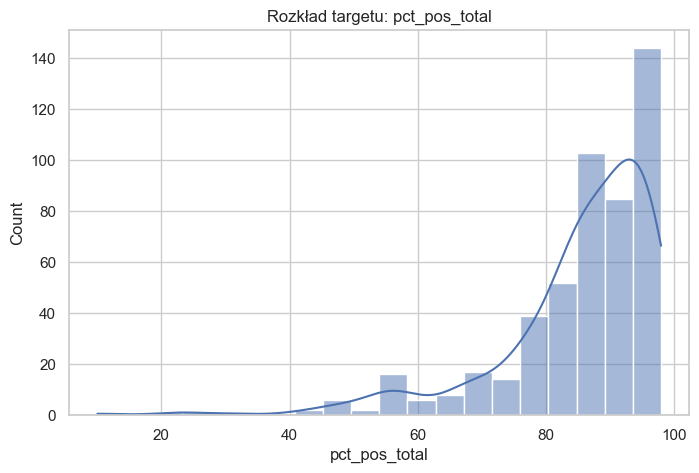


TOP 20 korelacji z targetem:
pct_pos_total                       1.000000
categories_Family Sharing           0.457929
categories_Steam Cloud              0.368712
metacritic_score                    0.344050
tags_Singleplayer                   0.329825
mac                                 0.311374
genres_Indie                        0.310786
tags_Indie                          0.308730
categories_Single-player            0.302034
tags_2D                             0.261230
categories_Remote Play on Tablet    0.250049
categories_Steam Trading Cards      0.247986
linux                               0.235115
categories_Remote Play on TV        0.225066
tags_Great Soundtrack               0.217421
categories_Remote Play on Phone     0.208342
supported_languages_English         0.205430
tags_Difficult                      0.190913
tags_Funny                          0.189340
tags_Story Rich                     0.185742
Name: pct_pos_total, dtype: float64


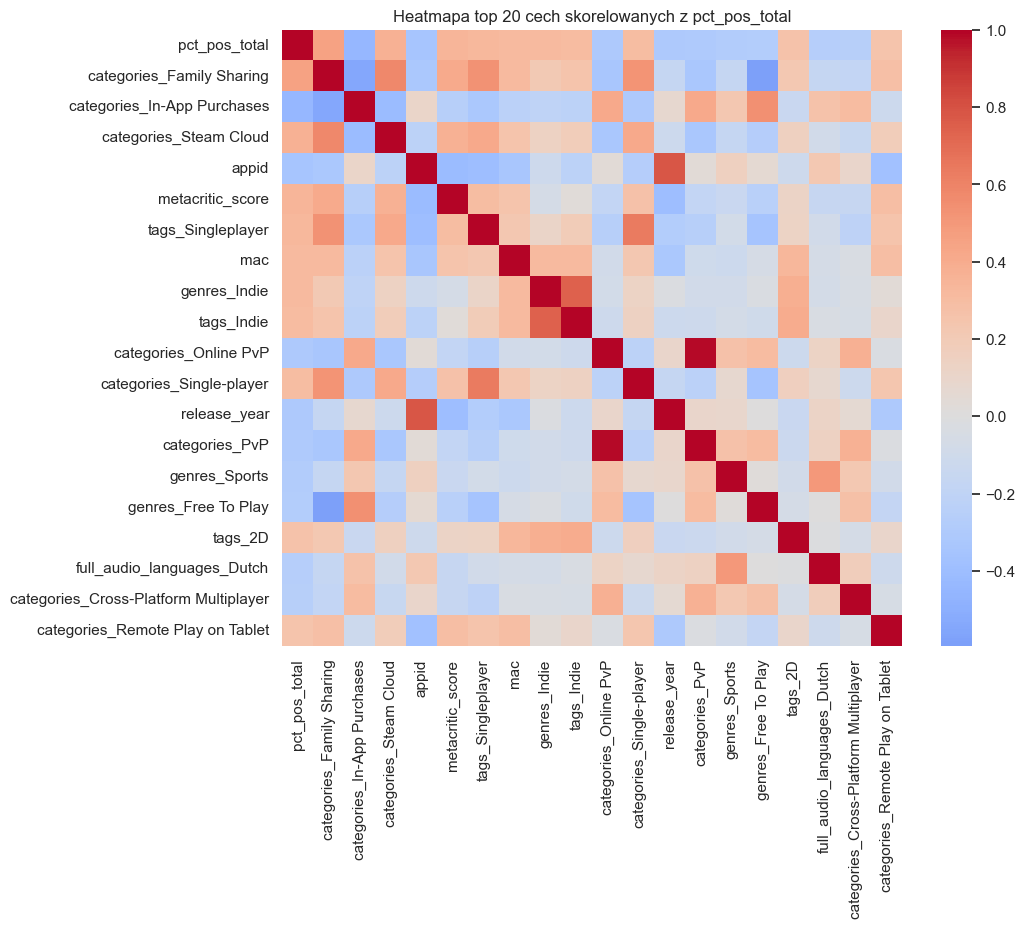

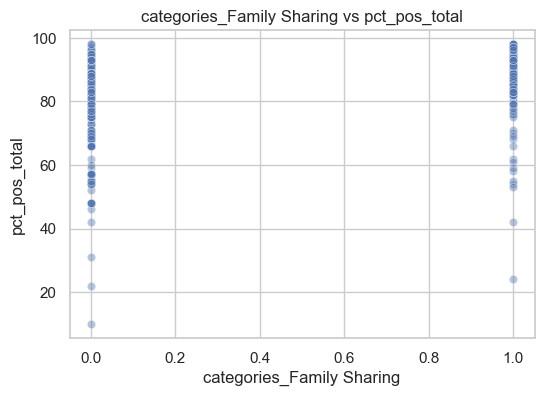

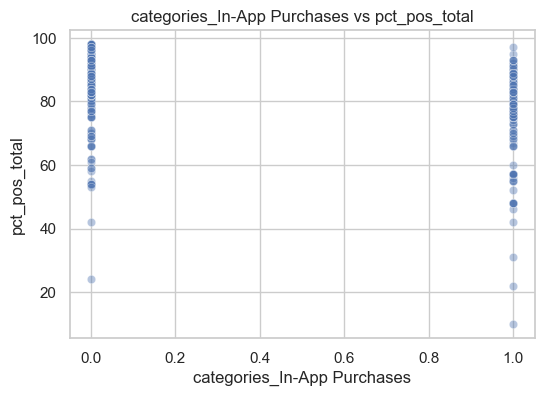

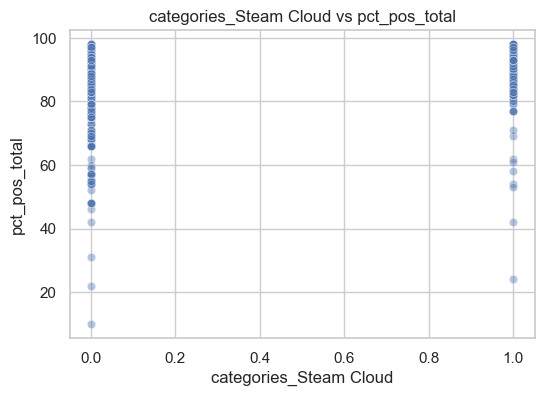

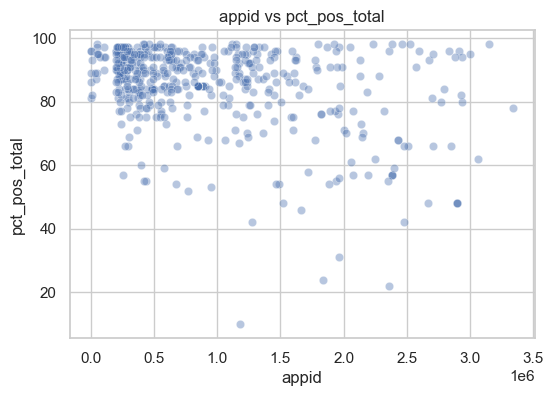

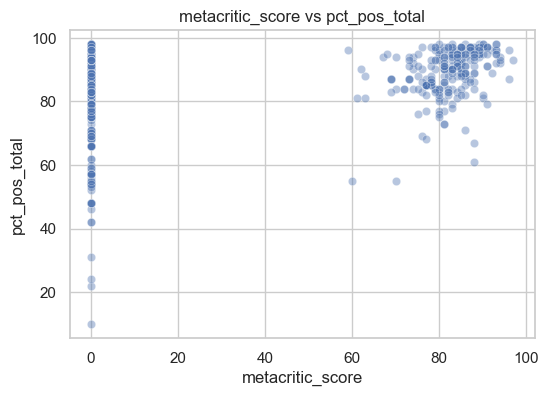


Cechy o bardzo niskiej korelacji (32):
['categories_Commentary available', 'categories_LAN PvP', 'full_audio_languages_Greek', 'full_audio_languages_Hungarian', 'tags_RPG', 'full_audio_languages_Croatian', 'categories_Partial Controller Support', 'average_playtime_forever', 'supported_languages_Hebrew', 'supported_languages_Thai', 'genres_Action', 'genres_Simulation', 'supported_languages_Macedonian', 'categories_Steam Turn Notifications', 'categories_SteamVR Collectibles', 'full_audio_languages_Romanian', 'num_reviews_total', 'supported_languages_Hindi', 'full_audio_languages_Portuguese - Portugal', 'tags_Multiplayer', 'has_support_url', 'full_audio_languages_Czech', 'categories_Captions available', 'full_audio_languages_Hindi', 'full_audio_languages_Vietnamese', 'categories_Steam Timeline', 'required_age', 'tags_Early Access', 'full_audio_languages_Serbian', 'supported_languages_Portuguese - Brazil', 'supported_languages_Polish', 'tags_Action RPG']


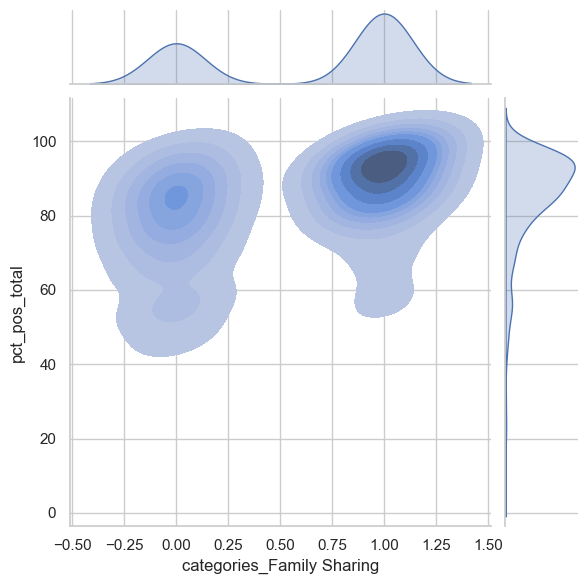

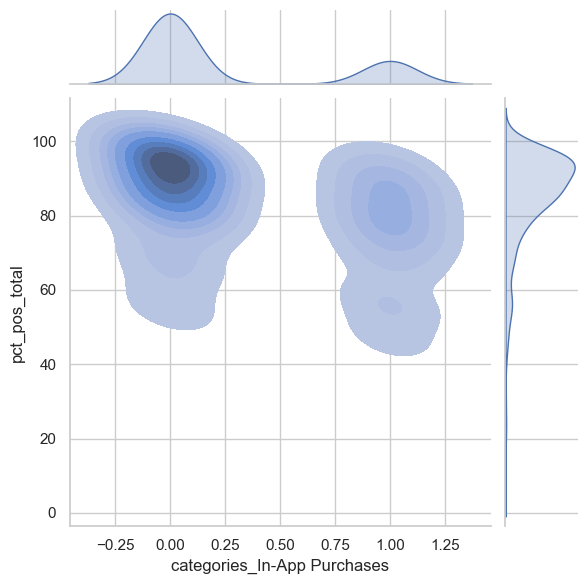

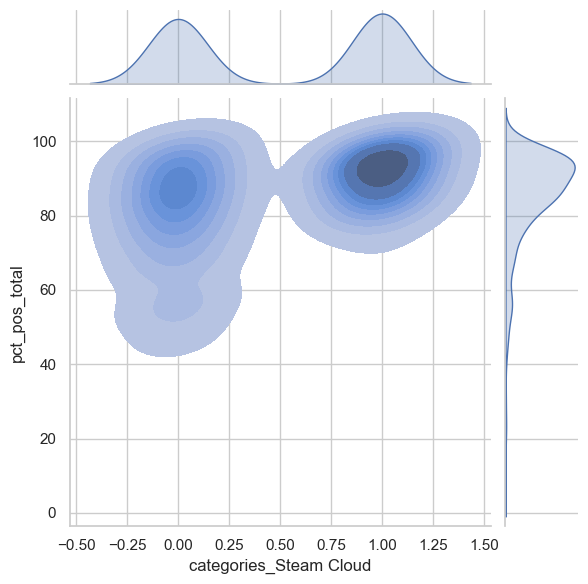

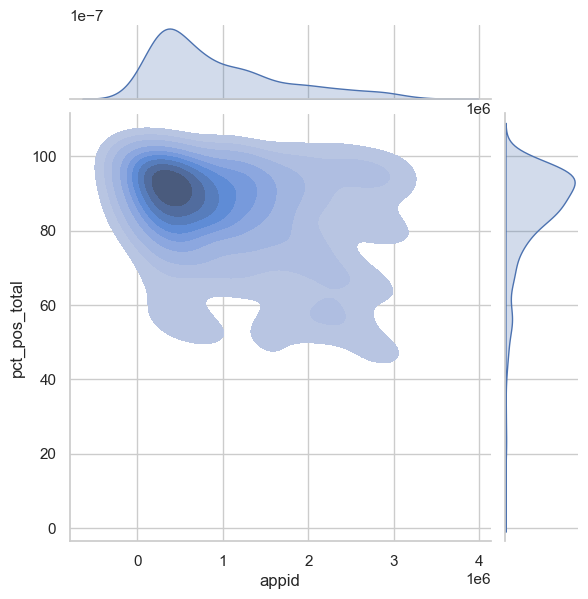

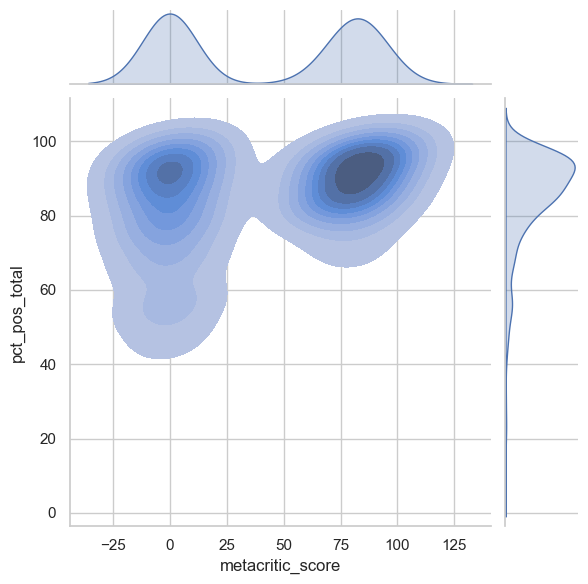

In [19]:
# target -> pct_pos_total

target = 'pct_pos_total'

# rozkład targetu
plt.figure(figsize=(8, 5))
sns.histplot(data[target], bins=20, kde=True)
plt.title("Rozkład targetu: pct_pos_total")
plt.show()

# ranking korelacji cech z targetem
corr_target = data.corr(numeric_only=True)[target].sort_values(ascending=False)
print("\nTOP 20 korelacji z targetem:")
print(corr_target.head(20))

# heatmap top 20
top_features = corr_target.abs().sort_values(ascending=False).head(20).index
plt.figure(figsize=(10, 8))
sns.heatmap(data[top_features].corr(), cmap='coolwarm', center=0)
plt.title("Heatmapa top 20 cech skorelowanych z pct_pos_total")
plt.show()

# scatterploty
strongest = corr_target.drop(target).abs().sort_values(ascending=False).head(5).index
for col in strongest:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=data[col], y=data[target], alpha=0.4)
    plt.title(f"{col} vs pct_pos_total")
    plt.show()

# jointploty
for col in strongest:
    sns.jointplot(data=data, x=col, y=target, kind='kde', fill=True)

# cechy bezużyteczne
low_corr = corr_target[abs(corr_target) < 0.02].index
print(f"\nCechy o bardzo niskiej korelacji ({len(low_corr)}):")
print(list(low_corr))

In [20]:
# podsumowanie
print(f"\nRozmiar danych po obróbce: {data.shape}")


Rozmiar danych po obróbce: (498, 218)


In [21]:
# eksport
output_path = f"../data/02_interim/cleaned_{filename}"
data.to_csv(output_path, index=False)
print(f"Dane zapisane do: {output_path}")

Dane zapisane do: ../data/02_interim/cleaned_top_500.csv
